## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

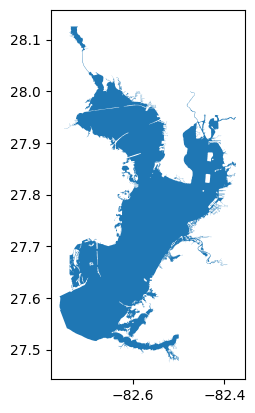

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:210: DtypeWarning: Columns (8,10,14,21,27,29,30,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [6]:
# Rows and columns for results
stations.shape

(16539, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:356: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  cond_notna = mask & (df_out["QA_flag"].notna())  # Mask cond and not NA
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(16539, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

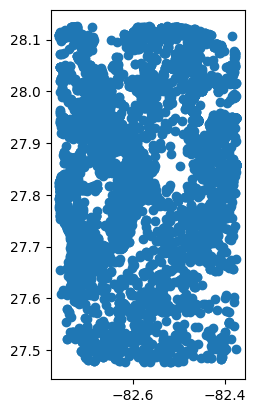

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

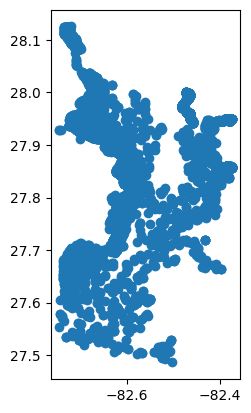

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10930

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,33,36,38,58,60,61,62,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537974,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-198091F-1980-0,1980-04-09,00:00:00,EST,21FLBSG-13,STORET-100013917591.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1537975,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980301F-1980-0,1980-07-30,00:00:00,EST,21FLBSG-13,STORET-100013919062.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1537976,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980223F-1980-0,1980-04-22,00:00:00,EST,21FLBSG-13,STORET-100013915213.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1537977,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980225F-1980-0,1980-04-22,00:00:00,EST,21FLBSG-13,STORET-100013907816.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


<Axes: >

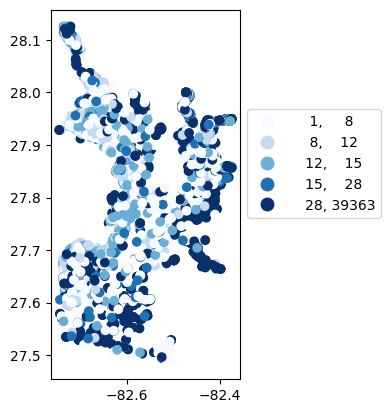

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ResultMeasureValue: "Not Reported" result cannot be used' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.8, 'meter')> <Quantity(2.2, 'meter')>
 <Quantity(2.7, 'meter')> ... <Quantity(2.3, 'meter')>
 <Quantity(1.4, 'meter')> <Quantity(1.6, 'meter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    92675.000000
mean         1.472673
std          0.908834
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 281
Usable results with inferred units: 1
Results outside threshold (0.0 to 6.925674654247189): 55


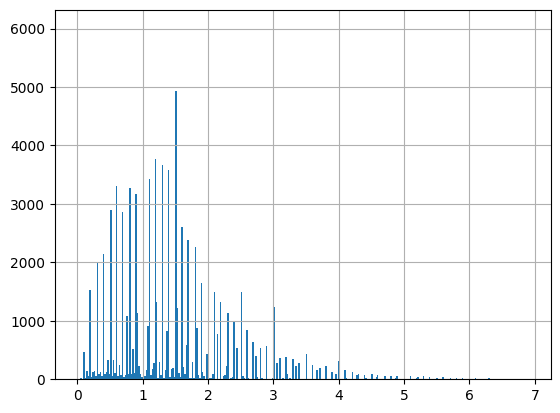

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
36,21FLHILL_WQX-1510,0.80,m,NaN,m,0.8 meter
68,21FLMANA_WQX-428,2.2,m,NaN,m,2.2 meter
96,21FLHILL_WQX-096,2.70,m,NaN,m,2.7 meter
106,21FLHILL_WQX-064,0.80,m,NaN,m,0.8 meter
127,21FLCOSP_WQX-COSPE6-2,1.7,m,NaN,m,1.7 meter
...,...,...,...,...,...,...
1537709,21FLBSG-13,1.4,m,NaN,m,1.4 meter
1537710,21FLBSG-13,1.6,m,NaN,m,1.6 meter
1537711,21FLBSG-13,2.3,m,NaN,m,2.3 meter
1537721,21FLBSG-13,1.4,m,NaN,m,1.4 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
510468,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
515365,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
518679,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
520604,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
522083,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1527298,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527351,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527354,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527640,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
368417,NARS_WQX-NCCA10-1674,-9,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",m,-9.0 meter
510468,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
515365,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
518679,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
520604,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1527298,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527351,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527354,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1527640,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
12165,USGS-280630082350900,3,1.966667
12166,USGS-280635082322100,2,2.100000
12167,USGS-280640082434700,3,2.302933
12168,USGS-280719082291400,2,1.000000


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


<Axes: >

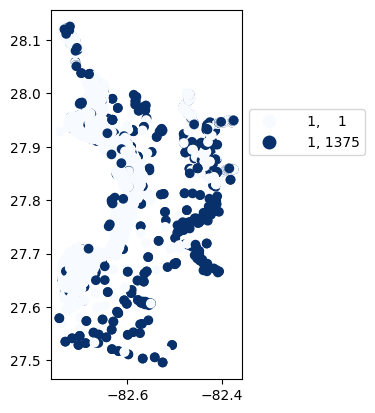

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

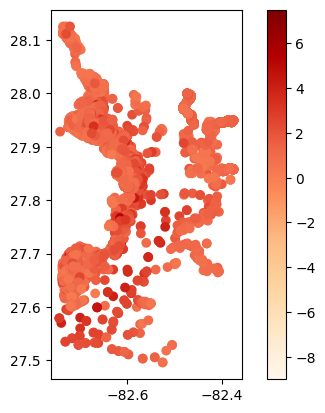

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(28.19, 'degree_Celsius')> <Quantity(29.52, 'degree_Celsius')>
 <Quantity(21.0, 'degree_Celsius')> ... <Quantity(14.9, 'degree_Celsius')>
 <Quantity(31.2, 'degree_Celsius')> <Quantity(30.1, 'degree_Celsius')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    313146.000000
mean         25.280097
std          78.216584
min          -2.900000
25%          21.200000
50%          25.860000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 174
Usable results with inferred units: 0
Results outside threshold (0.0 to 494.5795984781391): 2


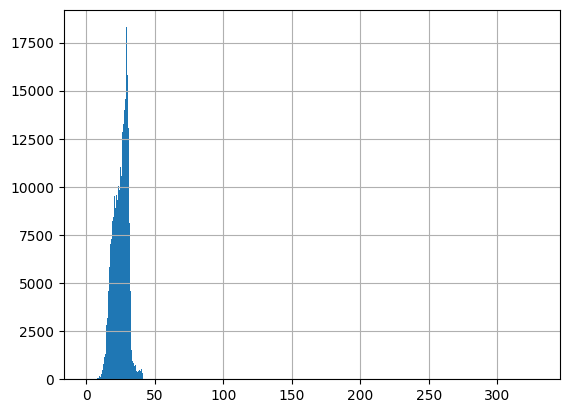

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
9,21FLTBW_WQX-M23,29.52,deg C,NaN,29.52 degree_Celsius,degC
14,21FLMANA_WQX-GA1,21,deg C,NaN,21.0 degree_Celsius,degC
34,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
37,21FLTBW_WQX-PR103026,17.73,deg C,NaN,17.73 degree_Celsius,degC
...,...,...,...,...,...,...
1537941,21FLBSG-13,22.5,deg C,NaN,22.5 degree_Celsius,degC
1537950,21FLBSG-13,14.6,deg C,NaN,14.6 degree_Celsius,degC
1537958,21FLBSG-13,14.9,deg C,NaN,14.9 degree_Celsius,degC
1537962,21FLBSG-13,31.2,deg C,NaN,31.2 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
514605,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
515694,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
517127,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
522167,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
528255,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
893017,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
896720,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1424104,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1521065,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
514605,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
515694,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
517127,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
522167,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
528255,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1139713,21FLPDEM_WQX-05-06,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1143210,21FLPDEM_WQX-12-02,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1424104,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1521065,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
15334,USGS-280726082313300,4,28.025000
15335,USGS-280728082301101,54,25.083333
15336,USGS-280729082313501,1,27.400000
15337,USGS-280730082313201,1,24.700000


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

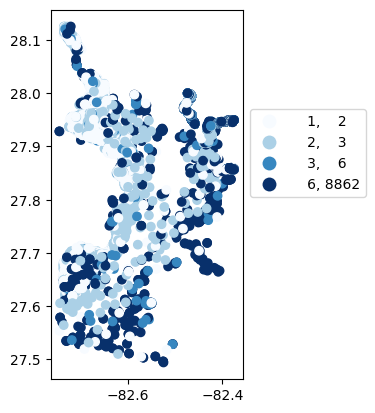

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

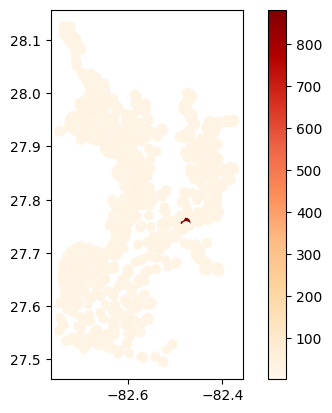

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(9.32, 'milligram / liter')>
 <Quantity(8.08, 'milligram / liter')>
 <Quantity(4.9, 'milligram / liter')> ...
 <Quantity(8.2, 'milligram / liter')> <Quantity(7.9, 'milligram / liter')>
 <Quantity(10.4, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1537974,21FLBSG-13,8.3,mg/l,NaN,8.3 milligram / liter
1537975,21FLBSG-13,12.4,mg/l,NaN,12.4 milligram / liter
1537976,21FLBSG-13,8.2,mg/l,NaN,8.2 milligram / liter
1537977,21FLBSG-13,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1498177,21FLHILL_WQX-36,7.66,mg/L,NaN,7.66 milligram / liter
1498179,21FLHILL_WQX-1608,5.75,mg/L,NaN,5.75 milligram / liter
1498190,21FLHILL_WQX-1611,7.09,mg/L,NaN,7.09 milligram / liter
1498193,21FLHILL_WQX-265,5.41,mg/L,NaN,5.41 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
13907,NARS_WQX-NCCA10-1672,8,5.437500
13908,NARS_WQX-NCCA10-1673,20,4.115000
13909,NARS_WQX-NCCA10-1674,6,2.466667
13910,NARS_WQX-NLA06608-0161,5,6.500000


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

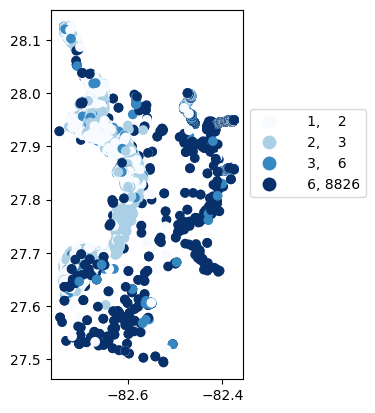

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

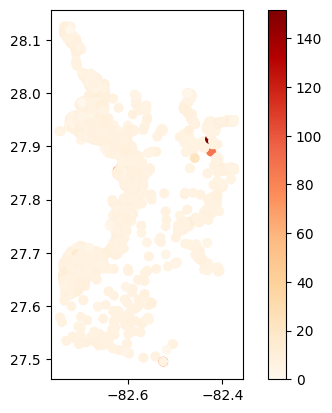

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.48, 'dimensionless')> <Quantity(8.18, 'dimensionless')>
 <Quantity(7.81, 'dimensionless')> ... <Quantity(7.8, 'dimensionless')>
 <Quantity(7.7, 'dimensionless')> <Quantity(7.6, 'dimensionless')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    289471.000000
mean          7.759410
std           0.472718
min           0.370000
25%           7.510000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 194
Usable results with inferred units: 270952
Results outside threshold (0.0 to 10.595716827907022): 7


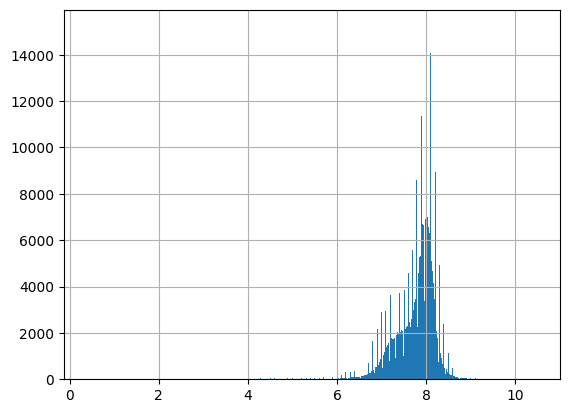

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.48 dimensionless
5,8.18,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.18 dimensionless
7,7.81,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.81 dimensionless
11,7.96,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.96 dimensionless
17,7.92,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.92 dimensionless
...,...,...,...,...
1535068,7.9,std units,NaN,7.9 dimensionless
1535069,7.3,std units,NaN,7.3 dimensionless
1535071,7.8,std units,NaN,7.8 dimensionless
1535072,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '@25C' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:510: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df[c_mask] = basis.update_result_basis(


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(40.0, 'Practical_Salinity_Units')>
 <Quantity(29.0, 'Practical_Salinity_Units')>
 <Quantity(26.04, 'Practical_Salinity_Units')> ...
 <Quantity(27.3, 'Practical_Salinity_Units')>
 <Quantity(23.2, 'Practical_Salinity_Units')>
 <Quantity(25.6, 'Practical_Salinity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    279633.000000
mean         21.577041
std          93.242129
min          -0.020000
25%          17.700000
50%          24.870000
75%          28.650000
max       48930.000000
dtype: float64
Unusable results: 1275
Usable results with inferred units: 0
Results outside threshold (0.0 to 581.029816481317): 4


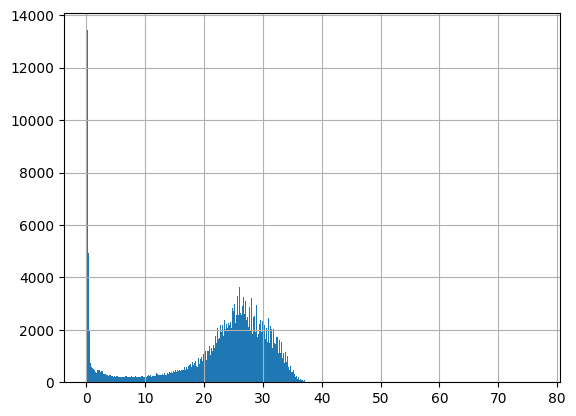

In [48]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
21,0.18,ppth,NaN,0.18 Practical_Salinity_Units
23,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1537953,25.0,PSS,NaN,25.0 Practical_Salinity_Units
1537955,22.8,PSS,NaN,22.8 Practical_Salinity_Units
1537956,27.3,PSS,NaN,27.3 Practical_Salinity_Units
1537957,23.2,PSS,NaN,23.2 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'as N' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:484: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 'as N'
 nan nan nan 'as N' nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan 'as N' nan 'as N' nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 'as N' nan nan nan nan
 'as N' nan 'as N' 'as N' nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly 

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.39, 'milligram / liter')>
 <Quantity(0.4475, 'milligram / liter')>
 <Quantity(0.425, 'milligram / liter')>
 <Quantity(0.4625, 'milligram / liter')>
 <Quantity(0.33625, 'milligram / liter')>
 <Quantity(0.28, 'milligram / liter')>
 <Quantity(0.5625, 'milligram / liter')>
 <Quantity(0.21875, 'milligram / liter')>
 <Quantity(0.629, 'milligram / liter')>
 <Quantity(0.505, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.325, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.456, 'milligram / liter')>
 <Quantity(0.183, 'milligram / liter')>
 <Quantity(0.526, 'milligram / liter')>
 <Quantity(0.264, 'milligram / liter')>
 <Quantity(0.188, 'milligram / liter')>
 <Quantity(0.346, 'milligram / liter')>
 <Quantity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtyp

-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


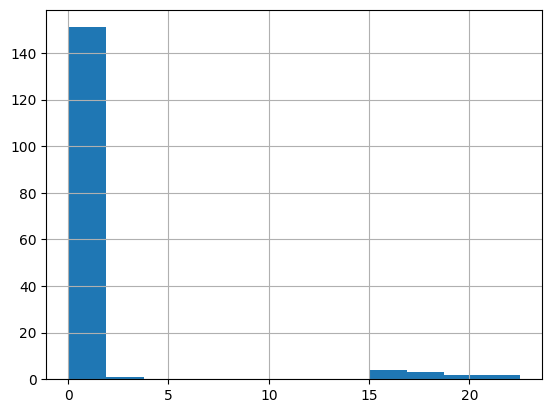

In [50]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
345628,0.39,mg/L,NaN,0.39 milligram / liter
361761,0.4475,mg/L,NaN,0.4475 milligram / liter
364554,0.425,mg/L,NaN,0.425 milligram / liter
378386,0.4625,mg/L,NaN,0.4625 milligram / liter
379775,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1534439,0.084,mg/l,NaN,0.084 milligram / liter
1534447,0.166,mg/l,NaN,0.166 milligram / liter
1534457,0.091,mg/l,NaN,0.091 milligram / liter
1534491,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(626.0, 'microsiemens / centimeter')>
 <Quantity(688.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(633.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(20500.0, 'microsiemens / centimeter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count       11.000000
mean      2503.363636
std       5969.279978
min        606.000000
25%        629.500000
50%        775.000000
75%        776.000000
max      20500.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 38319.04350375742): 0


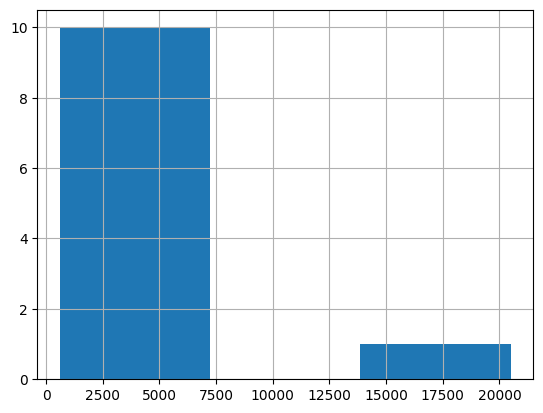

In [52]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
268114,626,uS/cm,NaN,626.0 microsiemens / centimeter
272480,688,uS/cm,NaN,688.0 microsiemens / centimeter
289873,606,uS/cm,NaN,606.0 microsiemens / centimeter
290979,606,uS/cm,NaN,606.0 microsiemens / centimeter
294202,633,uS/cm,NaN,633.0 microsiemens / centimeter
308158,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
312849,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
314286,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
316723,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
317588,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.0456, 'milligram / liter')>
 <Quantity(0.0456, 'milligram / liter')>
 <Quantity(0.0174, 'milligram / liter')> ...
 <Quantity(0.01098, 'milligram / liter')>
 <Quantity(0.03027, 'milligram / liter')>
 <Quantity(0.02559, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    43334.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008725
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.1508140878070869): 197


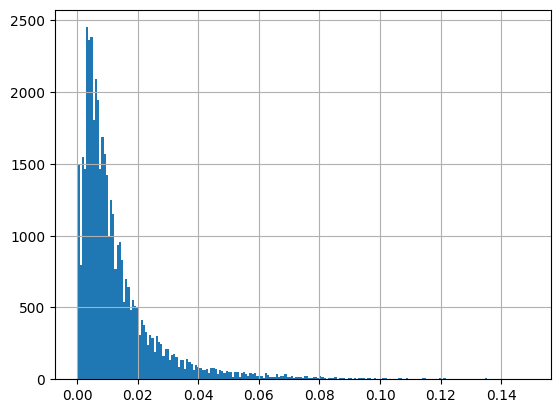

In [54]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
279028,45.6,ug/L,NaN,0.0456 milligram / liter
289064,45.6,ug/L,NaN,0.0456 milligram / liter
298849,17.4,ug/L,NaN,0.0174 milligram / liter
309220,11.38,ug/L,NaN,0.011380000000000001 milligram / liter
317394,3.24,ug/L,NaN,0.0032400000000000003 milligram / liter
...,...,...,...,...
1537952,49.06,ug/l,NaN,0.049060000000000006 milligram / liter
1537954,13.4,ug/l,NaN,0.0134 milligram / liter
1537959,10.98,ug/l,NaN,0.01098 milligram / liter
1537960,30.27,ug/l,NaN,0.030270000000000002 milligram / liter


##### Organic Carbon

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(3.8, 'milligram / liter')>
 <Quantity(19.5, 'milligram / liter')>
 <Quantity(11.3, 'milligram / liter')> ...
 <Quantity(4.8, 'milligram / liter')>
 <Quantity(12.9, 'milligram / liter')>
 <Quantity(3.7, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    2.407400e+04
mean     2.206620e+04
std      1.803432e+06
min      0.000000e+00
25%      4.540000e+00
50%      7.000000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1956
Usable results with inferred units: 0
Results outside threshold (0.0 to 10842655.304856202): 8


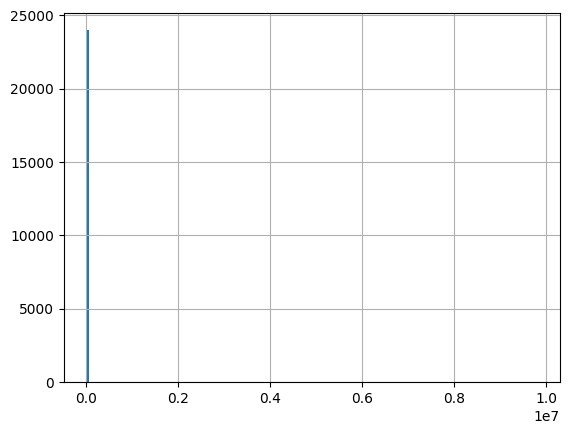

In [56]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
124,19.5,mg/L,NaN,19.5 milligram / liter
125,11.3,mg/L,NaN,11.3 milligram / liter
129,6.7,mg/L,NaN,6.7 milligram / liter
135,28.0,mg/L,NaN,28.0 milligram / liter
...,...,...,...,...
1533869,4.53,mg/l,NaN,4.53 milligram / liter
1533874,1.56,mg/l,NaN,1.56 milligram / liter
1533879,4.8,mg/l,NaN,4.8 milligram / liter
1533884,12.9,mg/l,NaN,12.9 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(4.49, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.2, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.9, 'Nephelometric_Turbidity_Units')> ...
 <Quantity(0.7, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.3, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.1, 'Nephelometric_Turbidity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count     96756.000000
mean         15.624784
std         851.847429
min          -0.047700
25%           1.500000
50%           2.500000
75%           4.100000
max      200000.000000
dtype: float64
Unusable results: 1149
Usable results with inferred units: 0
Results outside threshold (0.0 to 5126.709355321208): 157


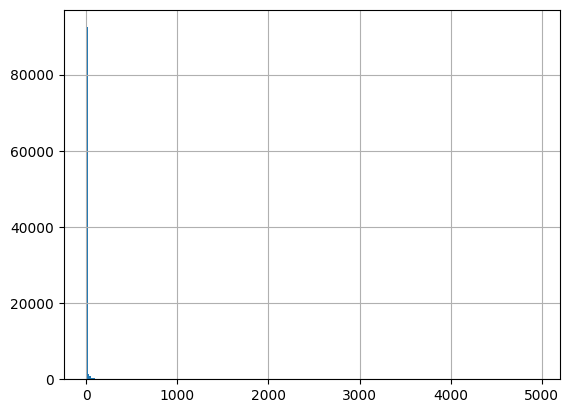

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
25,4.49,NTU,NaN,4.49 Nephelometric_Turbidity_Units
81,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
108,2.9,NTU,NaN,2.9 Nephelometric_Turbidity_Units
147,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
222,4.3,NTU,NaN,4.3 Nephelometric_Turbidity_Units
...,...,...,...,...
1533942,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1534152,0.9,NTRU,NaN,0.9 Nephelometric_Turbidity_Units
1534231,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1534271,2.3,NTRU,NaN,2.3 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.049, 'milligram / liter')>
 <Quantity(0.004, 'milligram / liter')>
 <Quantity(0.049, 'milligram / liter')> ...
 <Quantity(0.04, 'milligram / liter')>
 <Quantity(0.05, 'milligram / liter')>
 <Quantity(0.04, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
19612,0.050,mg/L,NaN,0.05 milligram / liter
...,...,...,...,...
1534736,0.065,mg/l as P,NaN,NaN
1534741,0.027,mg/l as P,NaN,NaN
1534747,0.04,mg/l as P,NaN,NaN
1534762,0.05,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
23731,0.004,mg/L,NaN,NaN
...,...,...,...,...
1534736,0.065,mg/l as P,NaN,NaN
1534741,0.027,mg/l as P,NaN,NaN
1534747,0.04,mg/l as P,NaN,NaN
1534762,0.05,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
19612,0.050,mg/L,NaN,0.05 milligram / liter
29925,0.009,mg/L,NaN,0.009 milligram / liter
56000,0.003,mg/L,NaN,0.003 milligram / liter
65845,0.050,mg/L,NaN,0.05 milligram / liter
70783,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1530107,0.35,mg/l as P,NaN,0.35 milligram / liter
1530110,0.2,mg/l as P,NaN,0.2 milligram / liter
1530115,0.22,mg/l as P,NaN,0.22 milligram / liter
1530138,0.18,mg/l as P,NaN,0.18 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
345948,0.13118375,mg/L,NaN,NaN
362715,0.1696225,mg/L,NaN,NaN
363153,0.0835825,mg/L,NaN,NaN
369444,0.16950375,mg/L,NaN,NaN
379076,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1525288,420.0,mg/kg as P,NaN,NaN
1525628,0.38,%,NaN,NaN
1525637,330.0,mg/kg as P,NaN,NaN
1533251,460.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(300.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(160.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(2.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 57146
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988216): 8


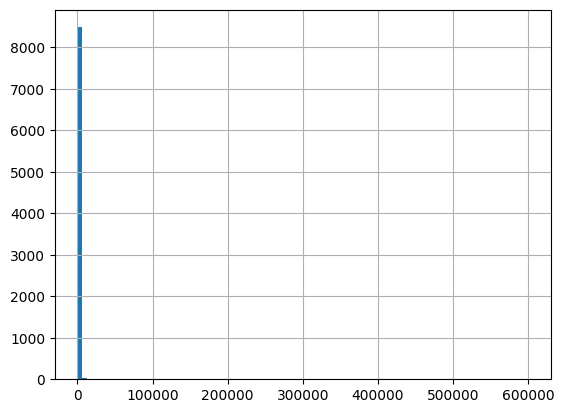

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
13,760,cfu/100mL,NaN,NaN
15,2900,cfu/100mL,NaN,NaN
55,300,#/100mL,NaN,NaN
72,280,#/100mL,NaN,NaN
109,52,cfu/100mL,NaN,NaN
...,...,...,...,...
1532254,100.0,cfu/100ml,NaN,100.0 Colony_Forming_Units / milliliter
1532293,1100.0,cfu/100ml,NaN,1100.0 Colony_Forming_Units / milliliter
1532381,300.0,cfu/100ml,NaN,300.0 Colony_Forming_Units / milliliter
1532435,160.0,cfu/100ml,NaN,160.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(110.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(32.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(20.0, 'Colony_Forming_Units / milliliter')>]' has dtype in

-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 7603
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


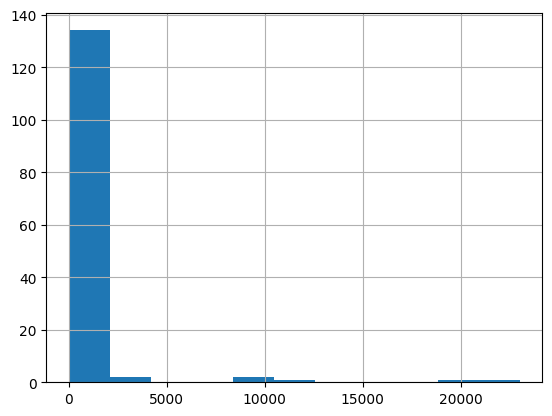

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
218670,210,MPN/100mL,NaN,NaN
220218,4800,MPN/100mL,NaN,NaN
220471,74.5,MPN/100mL,NaN,NaN
220737,553.9,MPN/100mL,NaN,NaN
221299,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1520462,200.0,cfu/100ml,NaN,200.0 Colony_Forming_Units / milliliter
1520567,4.0,cfu/100ml,NaN,4.0 Colony_Forming_Units / milliliter
1520604,110.0,cfu/100ml,NaN,110.0 Colony_Forming_Units / milliliter
1520629,32.0,cfu/100ml,NaN,32.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 279633 
Mean: 21.57704068945506 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
231008,48930,ppth,NaN,48930.0 Practical_Salinity_Units
285869,54.8,ppth,NaN,54.8 Practical_Salinity_Units
473519,76.57,ppth,NaN,76.57 Practical_Salinity_Units
662874,2976,ppth,NaN,2976.0 Practical_Salinity_Units
684335,68,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wrangle.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detection_df = pandas.concat(detection_list).drop_duplicates()


In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25645,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
25646,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46162,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46163,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
456971,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
584863,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
605980,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
795838,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1055340,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1058171,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

269381      626.0 microsiemens / centimeter
273772      688.0 microsiemens / centimeter
291282      606.0 microsiemens / centimeter
292404      606.0 microsiemens / centimeter
295652      633.0 microsiemens / centimeter
621908      776.0 microsiemens / centimeter
624663      776.0 microsiemens / centimeter
625595      775.0 microsiemens / centimeter
627685      776.0 microsiemens / centimeter
630892      775.0 microsiemens / centimeter
878300    20500.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
878300,20500,uS/cm,NaN,NaN,20500.0 microsiemens / centimeter
621908,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
624663,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
627685,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
625595,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
630892,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
273772,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
295652,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
269381,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
291282,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

878300    12.242 dimensionless
621908     0.379 dimensionless
624663     0.379 dimensionless
627685     0.379 dimensionless
625595     0.379 dimensionless
630892     0.379 dimensionless
273772     0.335 dimensionless
295652     0.308 dimensionless
269381     0.304 dimensionless
291282     0.294 dimensionless
292404     0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
878300,2021-09-17,NaN,NaN
621908,2007-08-15,NaN,NaN
624663,2007-08-15,NaN,NaN
627685,2007-08-15,NaN,NaN
625595,2007-08-15,NaN,NaN
...,...,...,...
1541618,1980-04-09,00:00:00,EST
1541619,1980-07-30,00:00:00,EST
1541620,1980-04-22,00:00:00,EST
1541621,1980-04-22,00:00:00,EST


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

,ActivityStartDate,Activity_datetime
878300,2021-09-17,NaT
621908,2007-08-15,NaT
624663,2007-08-15,NaT
627685,2007-08-15,NaT
625595,2007-08-15,NaT
...,...,...
1541618,1980-04-09,1980-04-09 05:00:00+00:00
1541619,1980-07-30,1980-07-30 05:00:00+00:00
1541620,1980-04-22,1980-04-22 05:00:00+00:00
1541621,1980-04-22,1980-04-22 05:00:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

273772     0.95
295652     0.50
269381     0.00
260706     3.25
262178     2.74
           ... 
1126625    0.33
1133105    0.33
1133992    0.33
1134282    0.30
1146447    0.33
Name: ResultDepthHeightMeasure/MeasureValue, Length: 505, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Salinity,QA_Secchi,QA_Fecal_Coliform,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Chlorophyll,QA_Nitrogen,QA_Conductivity,QA_DO
878300,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,2021-09-17,NaN,NaN,NARS_WQX-NWC_FL-10535,STORET-1040690254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621908,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624663,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
627685,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145209,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625595,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145207,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541618,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-198091F-1980-0,1980-04-09,00:00:00,EST,21FLBSG-13,STORET-100013917591.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541619,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980301F-1980-0,1980-07-30,00:00:00,EST,21FLBSG-13,STORET-100013919062.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541620,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980223F-1980-0,1980-04-22,00:00:00,EST,21FLBSG-13,STORET-100013915213.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541621,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1980225F-1980-0,1980-04-22,00:00:00,EST,21FLBSG-13,STORET-100013907816.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

72059 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_E_coli', 'QA_Carbon',
       'QA_Temperature', 'QA_pH', 'QA_Turbidity', 'QA_Salinity', 'QA_Secchi',
       'QA_Fecal_Coliform', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus', 'QA_Chlorophyll', 'QA_Nitrogen',
       'QA_Conductivity', 'QA_DO'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Salinity,QA_Secchi,QA_Fecal_Coliform,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Chlorophyll,QA_Nitrogen,QA_Conductivity,QA_DO
878300,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,NARS_WQX-NWC_FL-10535,STORET,NaN,NaN,NaN,NaN,12.242 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621908,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624663,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
627685,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625595,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Temperature',
 'QA_Turbidity',
 'QA_Salinity',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Nitrogen',
 'QA_Conductivity',
 'QA_DO']

<Axes: >

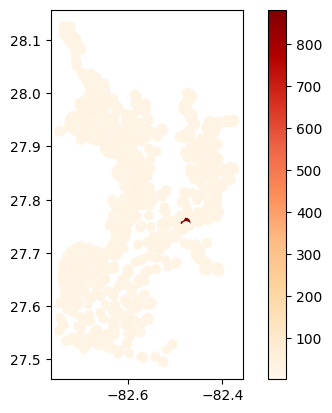

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)